In [2]:
import yfinance as yf
import numpy as np

# Define the assets for a single portfolio
assets = ['SPY', 'EFA', 'BND', 'GLD', 'VNQ', 'VIXY']  # U.S. Equities, International Equities, Bonds, Gold, Real Estate, Volatility

# Download historical data (5 years)
data = yf.download(assets, start="2018-01-01", end="2023-01-01")['Adj Close']

# Calculate annualized returns for each asset
returns = data.pct_change().mean() * 252  # 252 trading days in a year

# Prior returns (expected returns)
mu_prior = returns.values
print("Prior returns for the portfolio:")
print(mu_prior)

[*********************100%***********************]  6 of 6 completed

Prior returns for the portfolio:
[ 0.00254406  0.0336876   0.0712509   0.11110466 -0.12077353  0.0673471 ]


In [3]:
# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate the covariance matrix of the returns
covariances = returns.cov()

print("\nCovariance matrix of the assets:")
print(covariances)


Covariance matrix of the assets:
Ticker       BND       EFA       GLD       SPY      VIXY       VNQ
Ticker                                                            
BND     0.000014  0.000009  0.000011  0.000009 -0.000012  0.000015
EFA     0.000009  0.000156  0.000021  0.000150 -0.000449  0.000141
GLD     0.000011  0.000021  0.000082  0.000013 -0.000031  0.000021
SPY     0.000009  0.000150  0.000013  0.000184 -0.000521  0.000166
VIXY   -0.000012 -0.000449 -0.000031 -0.000521  0.002447 -0.000438
VNQ     0.000015  0.000141  0.000021  0.000166 -0.000438  0.000238


In [4]:
# Example function to create the views and confidence matrix
def create_views_and_confidence(views, confidence):
    """
    Create the views vector (Q) and the confidence matrix (Omega).
    
    Parameters:
    - views (list or numpy array): A list of views on expected returns for specific assets.
    - confidence (float): Confidence level for each view (scalar or list).
    
    Returns:
    - Q (numpy array): View vector.
    - Omega (numpy array): Confidence matrix.
    """
    Q = np.array(views)
    M = len(Q)
    
    # If confidence is a scalar, create a diagonal matrix with that confidence value
    if isinstance(confidence, (int, float)):
        Omega = np.diag([confidence] * M)
    else:
        Omega = np.diag(confidence)
    
    return Q, Omega

def create_linkage_matrix(views_assets, num_assets):
    """
    Create the linkage matrix (P) based on the number of assets and the views.
    
    Parameters:
    - views (list of tuples): Each view should be represented as a tuple (asset_indices, weight).
      For example, [(0, 1), (1, 2)] means two views, one on asset 0 (S&P500) and another on asset 1 (EFA).
    - num_assets (int): The total number of assets in the portfolio.

    Returns:
    - P (numpy array): The linkage matrix (M x N), where M is the number of views, and N is the number of assets.
    """
    M = len(views_assets)  # Number of views
    P = np.zeros((M, num_assets))  # Initialize P as a zero matrix
    
    for i, asset_idx in enumerate(views_assets):
        P[i, asset_idx] = 1  # Set the linkage for the specific asset in each view
    
    return P

# Function to compute the Black-Litterman posterior returns
def black_litterman(mu_prior, Sigma, P, Q, Omega):
    """
    Compute the posterior expected returns using the Black-Litterman model.
    
    Parameters:
    - mu_prior (numpy array): Prior (equilibrium) returns vector (N x 1).
    - Sigma (numpy array): Covariance matrix (N x N).
    - P (numpy array): Linkage matrix (M x N) that links views to assets.
    - Q (numpy array): View vector (M x 1) of expected returns for the views.
    - Omega (numpy array): Confidence matrix (M x M) representing the uncertainty in the views.
    
    Returns:
    - mu_post (numpy array): Posterior expected returns vector (N x 1).
    """
    # Invert the covariance matrix and confidence matrix
    Sigma_inv = np.linalg.inv(Sigma)
    Omega_inv = np.linalg.inv(Omega)
    
    # Compute the posterior mean returns using the Black-Litterman formula
    mu_post = np.linalg.inv(Sigma_inv + np.dot(np.dot(P.T, Omega_inv), P)) @ (
        np.dot(Sigma_inv, mu_prior) + np.dot(np.dot(P.T, Omega_inv), Q)
    )
    
    return mu_post

In [5]:
Sigma = covariances.values

# Define the investor views (e.g., expected returns for SPY and EFA)
views = [0.06, -0.05]  # Expected returns for SPY (6%) and EFA (-5%)
confidence = 0.02  # Relatively low confidence in views

# Create the views vector (Q) and the confidence matrix (Omega)
Q, Omega = create_views_and_confidence(views, confidence)

# Define the linkage matrix (P) for the views (SPY and EFA)
views_assets = [0, 1]  # Views on SPY (index 0) and EFA (index 1)
P = create_linkage_matrix(views_assets, len(mu_prior))

# Compute the posterior returns using Black-Litterman formula
mu_post = black_litterman(mu_prior, Sigma, P, Q, Omega)

# Output the results
print("Posterior Expected Returns (mu_post):")
print(mu_post)

Posterior Expected Returns (mu_post):
[ 0.00254959  0.03306491  0.07119478  0.11050476 -0.11894516  0.06680405]


In [6]:
import cvxpy as cp

# Example data
mu = np.array([0.12, 0.08, 0.15, 0.01, 0.11, 0.07])  # Expected returns

# Constraints
A = np.ones((1, len(mu)))  # Budget constraint
b = np.array([1.0])  # Budget
G = -np.eye(len(mu))  # No short positions
h = np.zeros(len(mu))

# Function for optimization
def optimize_portfolio(mu, Sigma, A, b, G, h, lambda_risk):
    """
    Optimize the portfolio with risk aversion.
    
    Parameters:
    - mu (numpy array): Expected returns vector (N x 1).
    - Sigma (numpy array): Covariance matrix (N x N).
    - A (numpy array): Equality constraint matrix.
    - b (numpy array): Equality constraint vector.
    - G (numpy array): Inequality constraint matrix.
    - h (numpy array): Inequality constraint vector (upper bounds).
    - lambda_risk (float): Risk aversion coefficient (higher value = more risk-averse).
    
    Returns:
    - w (numpy array): Optimal portfolio weights (N x 1).
    """
    # Define the optimization variables
    n = len(mu)
    w = cp.Variable(n)
    
    # Define the objective function: Maximize returns - risk (mean-variance)
    objective = cp.Maximize(mu.T @ w - (lambda_risk / 2) * cp.quad_form(w, Sigma))
    
    # Define the constraints
    constraints = [A @ w == b, G @ w <= h, w >= 0]  # Non-negative weights
    
    # Set up the problem
    prob = cp.Problem(objective, constraints)
    
    # Solve the problem
    prob.solve()
    
    return w.value

In [7]:
# Solve for optimized portfolio (Mean-Variance)
weights = optimize_portfolio(mu, Sigma, A, b, G, h, 1)
print("Optimized Portfolio Weights:")
print(weights)

Optimized Portfolio Weights:
[ 4.16339085e-23 -5.55106550e-23  1.00000000e+00  5.09410781e-28
 -2.77513302e-23  9.71784576e-28]


In [8]:
# Compute the posterior returns using Black-Litterman formula
mu_bl = black_litterman(mu, Sigma, P, Q, Omega)

# Solve for optimized portfolio (Black-Litterman)
weights_bl = optimize_portfolio(mu_bl, Sigma, A, b, G, h, 1)
print("Optimized Portfolio Weights (Black-Litterman):")
print(weights_bl)

Optimized Portfolio Weights (Black-Litterman):
[ 4.16339088e-23 -5.55106452e-23  1.00000000e+00  5.20781279e-28
 -2.77513763e-23 -5.55101690e-23]


In [9]:
benchmark_returns = mu_prior

# Compute active risk (deviation from the benchmark)
active_risk = np.std(mu_post - benchmark_returns)
print("Active Risk (standard deviation of returns):")
print(active_risk)

Active Risk (standard deviation of returns):
0.0008552403860984095


In [10]:
naive_Sigma = np.eye(6)
robust_Sigma = Sigma

# Compute the posterior returns using the naive covariance matrix
mu_post_naive = black_litterman(mu_prior, naive_Sigma, P, Q, Omega)

# Compute the posterior returns using the robust covariance matrix
mu_post_robust = black_litterman(mu_prior, robust_Sigma, P, Q, Omega)

# Output the posterior returns for comparison
print("Posterior Returns with Naive Covariance Matrix:")
print(mu_post_naive)

print("Posterior Returns with Robust Covariance Matrix:")
print(mu_post_robust)


Posterior Returns with Naive Covariance Matrix:
[ 0.05887341 -0.04835907  0.0712509   0.11110466 -0.12077353  0.0673471 ]
Posterior Returns with Robust Covariance Matrix:
[ 0.00254959  0.03306491  0.07119478  0.11050476 -0.11894516  0.06680405]


In [11]:
# Define three levels of risk aversion: low, medium, and high
risk_aversion_levels = [1, 5, 10]  # 1 (low), 5 (medium), 10 (high)

# Example: Compute optimal allocations for each level of risk aversion
for risk_aversion in risk_aversion_levels:
    # Adjust optimization parameters based on risk aversion
    # Here we assume a simple mean-variance optimization function:
    optimal_allocation = optimize_portfolio(mu, Sigma, A, b, G, h, risk_aversion)
    print(f"Optimal Allocation for Risk Aversion {risk_aversion}:")
    print(optimal_allocation)

Optimal Allocation for Risk Aversion 1:
[ 4.16339085e-23 -5.55106550e-23  1.00000000e+00  5.09410781e-28
 -2.77513302e-23  9.71784576e-28]
Optimal Allocation for Risk Aversion 5:
[6.95218140e-23 5.56253976e-23 1.00000000e+00 1.30030974e-25
 2.79851618e-23 1.17415980e-25]
Optimal Allocation for Risk Aversion 10:
[-4.11074210e-23 -5.50591974e-23  1.00000000e+00  5.14966395e-25
  8.41422590e-23  5.59710188e-23]


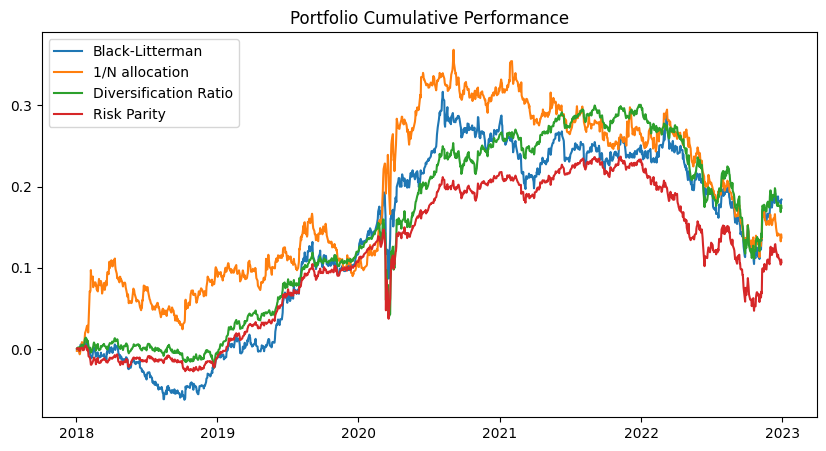

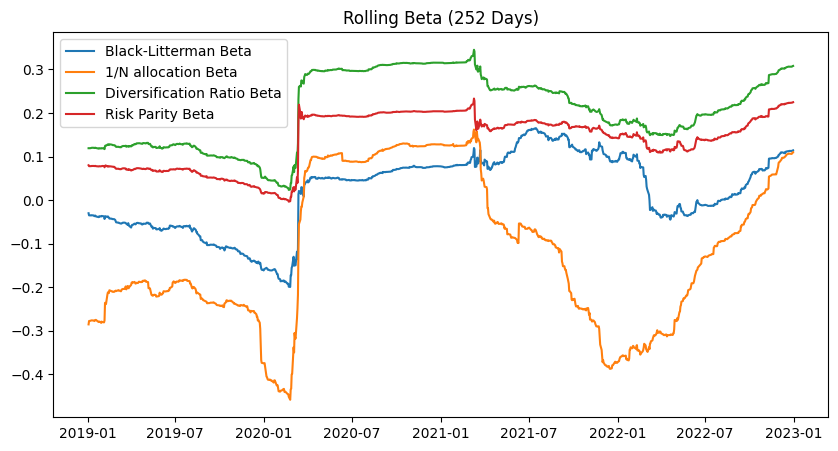

In [12]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.regression.rolling import RollingOLS

# Calculate mean returns
mean_returns = returns.mean()

bl_weights = optimize_portfolio(mu_bl, Sigma, np.ones((1, len(assets))), np.array([1]), np.eye(len(assets)), np.ones(len(assets)) * 0.5, 3)

# Benchmark Portfolios
# (a) Equal-Weight (1/N)
equal_weights = np.ones(len(assets)) / len(assets)

# (b) Diversification Ratio Portfolio
vols = returns.std().values
diversification_weights = 1 / vols
diversification_weights /= diversification_weights.sum()

# (c) Naive Risk Parity Portfolio
variances = returns.var().values
risk_parity_weights = 1 / variances
risk_parity_weights /= risk_parity_weights.sum()

# Portfolio Performance Comparison
portfolios = {
    'Black-Litterman': bl_weights,
    '1/N allocation': equal_weights,
    'Diversification Ratio': diversification_weights,
    'Risk Parity': risk_parity_weights
}

# Backtest each portfolio
portfolio_performance = {}
for name, weights in portfolios.items():
    portfolio_returns = (returns @ weights).cumsum()
    portfolio_performance[name] = portfolio_returns

plt.figure(figsize=(10, 5))
# Plot cumulative performance
for name, perf in portfolio_performance.items():
    plt.plot(perf, label=name)

plt.legend()
plt.title('Portfolio Cumulative Performance')
plt.show()

plt.figure(figsize=(10, 5))
# Rolling Beta with Factors
market_returns = returns['SPY']  # Proxy for market
rolling_betas = {}

for name, weights in portfolios.items():
    portfolio_returns = returns @ weights
    rolling_beta = RollingOLS(portfolio_returns, market_returns, window=252).fit().params
    rolling_betas[name] = rolling_beta

# Plot rolling betas
for name, beta in rolling_betas.items():
    plt.plot(beta, label=f'{name} Beta')
plt.legend()
plt.title('Rolling Beta (252 Days)')
plt.show()

In [13]:
# Function to compute performance metrics
def compute_performance_metrics(portfolio_returns, risk_free_rate=0.02 / 252):
    # Excess returns
    excess_returns = portfolio_returns - risk_free_rate

    # Sharpe ratio
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)

    # Cumulative returns
    cumulative_returns = (1 + portfolio_returns).cumprod()

    # Maximum drawdown
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()

    # Volatility (annualized)
    volatility = np.std(portfolio_returns) * np.sqrt(252)

    return sharpe_ratio, max_drawdown, volatility


# Calculate performance metrics for each portfolio
risk_free_rate = 0.02 / 252  # Assume 2% annualized risk-free rate
metrics = {}

for name, weights in portfolios.items():
    portfolio_returns = (returns @ weights)  # Daily portfolio returns
    sharpe, mdd, vol = compute_performance_metrics(portfolio_returns, risk_free_rate)
    metrics[name] = {'Sharpe Ratio': sharpe, 'Max Drawdown': mdd, 'Volatility': vol}

# Display the results
for name, stats in metrics.items():
    print(f"{name} Portfolio:")
    print(f"  Sharpe Ratio: {stats['Sharpe Ratio']:.2f}")
    print(f"  Maximum Drawdown: {stats['Max Drawdown']:.2%}")
    print(f"  Volatility: {stats['Volatility']:.2%}")
    print()

Black-Litterman Portfolio:
  Sharpe Ratio: 0.20
  Maximum Drawdown: -19.80%
  Volatility: 8.66%

1/N allocation Portfolio:
  Sharpe Ratio: 0.08
  Maximum Drawdown: -23.19%
  Volatility: 9.65%

Diversification Ratio Portfolio:
  Sharpe Ratio: 0.19
  Maximum Drawdown: -17.55%
  Volatility: 7.84%

Risk Parity Portfolio:
  Sharpe Ratio: 0.02
  Maximum Drawdown: -17.52%
  Volatility: 6.59%

